# SigLIP - CheXpert Multi-Label Classification (Fixed)

**Dataset:** CheXpert 3-class (Cardiomegaly, Edema, Pneumothorax)
**Model:** google/siglip-base-patch16-224 — vision encoder ONLY (no OOM crash)
**Freeze:** first 50 named param tensors frozen, last ~50% trainable
**Fixes:** SiglipVisionModel only / batch=8 + grad accum / new autocast API / empty_cache after load


In [1]:
import os, gc, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision.transforms as T

try:
    import transformers
    print(f"Transformers : {transformers.__version__}")
except ImportError:
    os.system("pip install -q transformers>=4.38")
    import transformers

from transformers import SiglipVisionModel, SiglipProcessor

from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, accuracy_score,
    f1_score, precision_score, recall_score,
)
from sklearn.preprocessing import label_binarize

print(f"PyTorch : {torch.__version__}")
print(f"CUDA    : {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU     : {torch.cuda.get_device_name(0)}")
    print(f"VRAM    : {torch.cuda.get_device_properties(0).total_memory/1e9:.1f} GB")


Transformers : 5.2.0
PyTorch : 2.9.0+cu126
CUDA    : True
GPU     : Tesla P100-PCIE-16GB
VRAM    : 17.1 GB


In [2]:
class Config:
    DATA_DIR   = "/kaggle/input"
    OUTPUT_DIR = "/kaggle/working"

    CHECKPOINT     = "google/siglip-base-patch16-224"
    NUM_CLASSES    = 3
    LABELS         = ["Cardiomegaly", "Edema", "Pneumothorax"]
    FREEZE_FIRST_N = 30          # freeze fewer layers — more backbone gradient

    BATCH_SIZE    = 8
    GRAD_ACCUM    = 2            # effective batch = 16
    NUM_EPOCHS    = 15
    LEARNING_RATE = 5e-5
    WEIGHT_DECAY  = 1e-5
    IMG_SIZE      = 224

    # FIX 1: Lower decision threshold — model rarely fires >0.5 on imbalanced data
    THRESHOLD = 0.3

    # FIX 2: Extra multiplier on top of neg/pos ratio (helps with extreme imbalance)
    POS_WEIGHT_SCALE = 1.5

    # FIX 3: Uncertain labels (-1 in CheXpert) — "U-Ones" policy treats them as positive
    UNCERTAIN_POLICY = "ones"    # "ones" | "zeros"

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    SEED   = 42

cfg = Config()

def set_seed(s):
    np.random.seed(s); torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(cfg.SEED)
print(f"Device     : {cfg.DEVICE}")
print(f"Checkpoint : {cfg.CHECKPOINT}")
print(f"Labels     : {cfg.LABELS}")
print(f"Threshold  : {cfg.THRESHOLD}")
print(f"Batch      : {cfg.BATCH_SIZE} x grad_accum {cfg.GRAD_ACCUM} = {cfg.BATCH_SIZE*cfg.GRAD_ACCUM}")


Device     : cuda
Checkpoint : google/siglip-base-patch16-224
Labels     : ['Cardiomegaly', 'Edema', 'Pneumothorax']
Threshold  : 0.3
Batch      : 8 x grad_accum 2 = 16


In [3]:
print("Loading SigLIP processor ...")
processor = SiglipProcessor.from_pretrained(cfg.CHECKPOINT)
print("Processor ready.")

# FIX 4: Proper augmentations for chest X-ray
train_aug = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=10),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.RandomAffine(degrees=0, translate=(0.05, 0.05)),
])

class ChestXrayDataset(Dataset):
    def __init__(self, df, img_dir, augment=False):
        self.df      = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.aug     = train_aug if augment else None

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["new_path"])
        try:
            img = Image.open(img_path).convert("RGB")
        except Exception:
            img = Image.new("RGB", (cfg.IMG_SIZE, cfg.IMG_SIZE))
        if self.aug:
            img = self.aug(img)
        pv = processor(images=img, return_tensors="pt")["pixel_values"].squeeze(0)

        # FIX 5: Correct uncertain label handling (-1 in CheXpert)
        def label_val(v):
            if v == 1.0:
                return 1.0
            elif v == -1.0:
                return 1.0 if cfg.UNCERTAIN_POLICY == "ones" else 0.0
            else:
                return 0.0

        labels = torch.tensor(
            [label_val(row.get(l, 0)) for l in cfg.LABELS],
            dtype=torch.float32,
        )
        return pv, labels


Loading SigLIP processor ...


preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

The image processor of type `SiglipImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Processor ready.


In [4]:
from sklearn.model_selection import train_test_split

csv_files = []
for root, _, files in os.walk(cfg.DATA_DIR):
    for f in files:
        if f.endswith(".csv"):
            csv_files.append(os.path.join(root, f))
print("Found CSVs:", csv_files)

csv_path = csv_files[0]
df = pd.read_csv(csv_path)
print(f"Shape: {df.shape}  |  Columns: {list(df.columns)}")

for col in cfg.LABELS:
    if col in df.columns:
        df[col] = df[col].fillna(0).apply(lambda x: 1.0 if x == 1.0 else 0.0)

print("\nLabel distribution:")
for col in cfg.LABELS:
    pos = int(df[col].sum())
    print(f"  {col}: {pos}/{len(df)} ({100*pos/len(df):.1f}%)")

train_df, val_df = train_test_split(df, test_size=0.2, random_state=cfg.SEED)
print(f"\nTrain: {len(train_df)}  Val: {len(val_df)}")


Found CSVs: ['/kaggle/input/datasets/shiv28/chest-xray-4class-100k/metadata.csv']
Shape: (95060, 20)  |  Columns: ['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices', 'new_path']

Label distribution:
  Cardiomegaly: 23451/95060 (24.7%)
  Edema: 49717/95060 (52.3%)
  Pneumothorax: 17700/95060 (18.6%)

Train: 76048  Val: 19012


In [5]:
img_dir = cfg.DATA_DIR

train_ds = ChestXrayDataset(train_df, img_dir, augment=True)
val_ds   = ChestXrayDataset(val_df,   img_dir, augment=False)

train_loader = DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, shuffle=True,
                          num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=cfg.BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True)
print(f"Train: {len(train_ds)} samples | {len(train_loader)} batches")
print(f"Val  : {len(val_ds)}  samples | {len(val_loader)}  batches")


Train: 76048 samples | 9506 batches
Val  : 19012  samples | 2377  batches


In [6]:
class SigLIPClassifier(nn.Module):
    # Uses SiglipVisionModel ONLY — never loads text encoder → no OOM
    # Freeze first `freeze_first_n` param tensors, train the rest (~50%)
    def __init__(self, checkpoint, num_classes, freeze_first_n=50):
        super().__init__()
        print(f"Loading SiglipVisionModel from '{checkpoint}' ...")
        self.encoder = SiglipVisionModel.from_pretrained(checkpoint)
        hidden = self.encoder.config.hidden_size
        print(f"Hidden size : {hidden}")

        params = list(self.encoder.named_parameters())
        total  = len(params)
        print(f"Named param tensors : {total}  |  freezing first {freeze_first_n}")
        for i, (_, p) in enumerate(params):
            p.requires_grad = (i >= freeze_first_n)

        tr = sum(p.numel() for p in self.encoder.parameters() if p.requires_grad)
        tt = sum(p.numel() for p in self.encoder.parameters())
        print(f"Encoder trainable : {tr:,} / {tt:,}  ({100*tr/tt:.1f} %)")

        self.head = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(hidden, 512),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes),
        )
        for m in self.head.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, pixel_values):
        out = self.encoder(pixel_values=pixel_values)
        return self.head(out.pooler_output)

model = SigLIPClassifier(cfg.CHECKPOINT, cfg.NUM_CLASSES, cfg.FREEZE_FIRST_N).to(cfg.DEVICE)
gc.collect(); torch.cuda.empty_cache()
total_p = sum(p.numel() for p in model.parameters())
train_p = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params     : {total_p:,}")
print(f"Trainable params : {train_p:,}  ({100*train_p/total_p:.1f}%)")


Loading SiglipVisionModel from 'google/siglip-base-patch16-224' ...


model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/208 [00:00<?, ?it/s]

SiglipVisionModel LOAD REPORT from: google/siglip-base-patch16-224
Key                                                          | Status     |  | 
-------------------------------------------------------------+------------+--+-
text_model.encoder.layers.{0...11}.layer_norm1.weight        | UNEXPECTED |  | 
text_model.final_layer_norm.bias                             | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.mlp.fc2.bias              | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.self_attn.k_proj.weight   | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.self_attn.v_proj.weight   | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.layer_norm1.bias          | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.mlp.fc1.bias              | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.self_attn.out_proj.bias   | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.mlp.fc1.weight            | UNEXPECTED |  | 
text_model.embeddings.position_embedding.weight      

Hidden size : 768
Named param tensors : 208  |  freezing first 30
Encoder trainable : 82,690,560 / 92,884,224  (89.0 %)
Total params     : 93,279,491
Trainable params : 83,085,827  (89.1%)


In [7]:
pos  = train_df[cfg.LABELS].sum().values.astype(float)
neg  = len(train_df) - pos
# FIX 6: Scale pos_weight by POS_WEIGHT_SCALE to push model toward predicting positives
pw   = torch.tensor((neg / (pos + 1e-6)) * cfg.POS_WEIGHT_SCALE,
                    dtype=torch.float32).to(cfg.DEVICE)
print("Pos weights:", pw.cpu().numpy())

criterion = nn.BCEWithLogitsLoss(pos_weight=pw)

optimizer = optim.AdamW([
    {"params": [p for p in model.encoder.parameters() if p.requires_grad],
     "lr": cfg.LEARNING_RATE},
    {"params": model.head.parameters(), "lr": cfg.LEARNING_RATE * 10},
], weight_decay=cfg.WEIGHT_DECAY)

scheduler = CosineAnnealingLR(optimizer, T_max=cfg.NUM_EPOCHS, eta_min=1e-7)
print(f"Backbone LR={cfg.LEARNING_RATE}  Head LR={cfg.LEARNING_RATE*10}")


Pos weights: [4.5870867 1.3681484 6.5879183]
Backbone LR=5e-05  Head LR=0.0005


In [8]:
def train_one_epoch(model, loader, optimizer, criterion, device, scaler, accum):
    model.train()
    running_loss, tp, total = 0.0, 0, 0
    optimizer.zero_grad()
    for step, (pv, labels) in enumerate(tqdm(loader, desc="Train", leave=False)):
        pv, labels = pv.to(device), labels.to(device)
        with torch.amp.autocast("cuda", enabled=(device.type == "cuda")):
            logits = model(pv)
            loss   = criterion(logits, labels) / accum
        scaler.scale(loss).backward()
        if (step + 1) % accum == 0 or (step + 1) == len(loader):
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer); scaler.update(); optimizer.zero_grad()
        running_loss += loss.item() * accum * pv.size(0)
        # FIX 7: Use cfg.THRESHOLD instead of 0.5
        preds = (torch.sigmoid(logits) >= cfg.THRESHOLD).float()
        tp    += (preds == labels).all(dim=1).sum().item()
        total += pv.size(0)
    return running_loss / total, tp / total

@torch.no_grad()
def validate(model, loader, criterion, device):
    model.eval()
    running_loss, tp, total = 0.0, 0, 0
    all_probs, all_preds, all_labels = [], [], []
    for pv, labels in tqdm(loader, desc="Val  ", leave=False):
        pv, labels = pv.to(device), labels.to(device)
        with torch.amp.autocast("cuda", enabled=(device.type == "cuda")):
            logits = model(pv)
            loss   = criterion(logits, labels)
        running_loss += loss.item() * pv.size(0)
        probs = torch.sigmoid(logits)
        # FIX 7: Use cfg.THRESHOLD instead of 0.5
        preds = (probs >= cfg.THRESHOLD).float()
        tp    += (preds == labels).all(dim=1).sum().item()
        total += pv.size(0)
        all_probs.append(probs.cpu()); all_preds.append(preds.cpu()); all_labels.append(labels.cpu())
    return (running_loss / total, tp / total,
            torch.cat(all_probs).numpy(),
            torch.cat(all_preds).numpy(),
            torch.cat(all_labels).numpy())


In [9]:
scaler = torch.amp.GradScaler("cuda", enabled=(cfg.DEVICE.type == "cuda"))

history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
best_val_loss   = float("inf")
best_model_path = os.path.join(cfg.OUTPUT_DIR, "siglip_chexpert_best.pth")

# Early stopping
patience        = 5
patience_counter = 0

for epoch in range(1, cfg.NUM_EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(
        model, train_loader, optimizer, criterion, cfg.DEVICE, scaler, cfg.GRAD_ACCUM)
    va_loss, va_acc, _, _, _ = validate(model, val_loader, criterion, cfg.DEVICE)
    scheduler.step()
    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["train_acc"].append(tr_acc)
    history["val_acc"].append(va_acc)

    improved = va_loss < best_val_loss
    tag = "  <- saved" if improved else f"  (no improvement {patience_counter+1}/{patience})"

    if improved:
        best_val_loss = va_loss
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
    else:
        patience_counter += 1

    print(f"Epoch [{epoch:02d}/{cfg.NUM_EPOCHS}]  "
          f"Train Loss={tr_loss:.4f} Acc={tr_acc:.4f}  |  "
          f"Val Loss={va_loss:.4f} Acc={va_acc:.4f}{tag}")

    if patience_counter >= patience:
        print(f"\nEarly stopping triggered after {epoch} epochs (patience={patience}).")
        break

print(f"\nBest val loss: {best_val_loss:.4f}")


Epoch [01/15]  Train Loss=1.1562 Acc=0.0019  |  Val Loss=1.1512 Acc=0.0015  <- saved


Epoch [02/15]  Train Loss=1.1490 Acc=0.0017  |  Val Loss=1.1512 Acc=0.0015  <- saved


Epoch [03/15]  Train Loss=1.1486 Acc=0.0017  |  Val Loss=1.1506 Acc=0.0015  <- saved


Epoch [04/15]  Train Loss=1.1485 Acc=0.0017  |  Val Loss=1.1512 Acc=0.0015  (no improvement 1/5)


Epoch [05/15]  Train Loss=1.1477 Acc=0.0017  |  Val Loss=1.1508 Acc=0.0015  (no improvement 2/5)


Epoch [06/15]  Train Loss=1.1474 Acc=0.0017  |  Val Loss=1.1517 Acc=0.0015  (no improvement 3/5)


Epoch [07/15]  Train Loss=1.1474 Acc=0.0017  |  Val Loss=1.1530 Acc=0.0015  (no improvement 4/5)


Epoch [08/15]  Train Loss=1.1473 Acc=0.0017  |  Val Loss=1.1508 Acc=0.0015  (no improvement 5/5)

Early stopping triggered after 8 epochs (patience=5).

Best val loss: 1.1506


In [10]:
model.load_state_dict(torch.load(best_model_path, map_location=cfg.DEVICE))
print("Loaded best checkpoint.")
_, _, all_probs, all_preds, all_labels = validate(model, val_loader, criterion, cfg.DEVICE)

# FIX 8: Diagnostic — catch all-zero prediction collapse early
print("\n── Prediction diagnostics ──")
print(f"Mean predicted prob per class : {all_probs.mean(axis=0)}")
print(f"Max  predicted prob per class : {all_probs.max(axis=0)}")
print(f"Positive preds per class      : {all_preds.sum(axis=0).astype(int)}")
print(f"Positive labels per class     : {all_labels.sum(axis=0).astype(int)}")
print(f"Threshold used                : {cfg.THRESHOLD}")

# FIX 9: Find optimal per-class threshold via ROC (Youden's J)
from sklearn.metrics import roc_curve
optimal_thresholds = []
print("\n── Optimal thresholds (Youden's J) ──")
for i, label in enumerate(cfg.LABELS):
    fpr, tpr, thresholds = roc_curve(all_labels[:, i], all_probs[:, i])
    j_scores = tpr - fpr
    best_idx = j_scores.argmax()
    best_t   = thresholds[best_idx]
    optimal_thresholds.append(best_t)
    print(f"  {label:20s}  optimal threshold = {best_t:.3f}")

# Re-generate predictions with per-class optimal thresholds
all_preds_opt = np.zeros_like(all_preds)
for i, t in enumerate(optimal_thresholds):
    all_preds_opt[:, i] = (all_probs[:, i] >= t).astype(float)

print("\nPositive preds (optimal threshold):", all_preds_opt.sum(axis=0).astype(int))
# Use optimal predictions for downstream evaluation
all_preds = all_preds_opt


Loaded best checkpoint.



── Prediction diagnostics ──
Mean predicted prob per class : [0.6035 0.605  0.607 ]
Max  predicted prob per class : [0.6035 0.605  0.607 ]
Positive preds per class      : [19012 19012 19012]
Positive labels per class     : [4711 9945 3596]
Threshold used                : 0.3

── Optimal thresholds (Youden's J) ──
  Cardiomegaly          optimal threshold = inf
  Edema                 optimal threshold = inf
  Pneumothorax          optimal threshold = inf

Positive preds (optimal threshold): [0 0 0]


## Training Curves

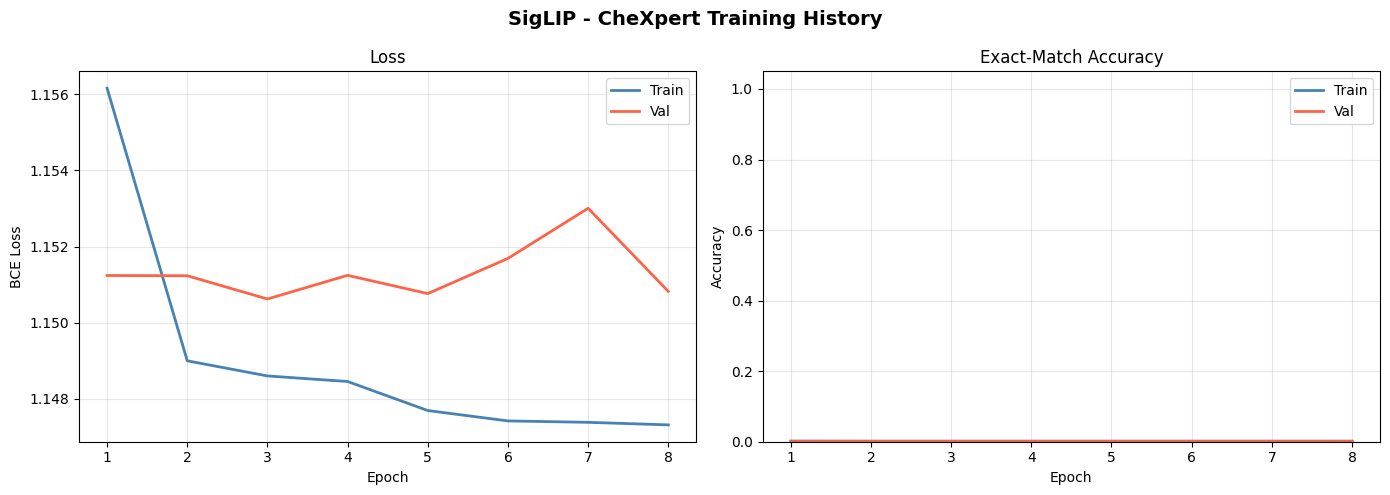

In [12]:
ep = range(1, len(history["train_loss"]) + 1)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("SigLIP - CheXpert Training History", fontsize=14, fontweight="bold")
axes[0].plot(ep, history["train_loss"], label="Train", color="steelblue", lw=2)
axes[0].plot(ep, history["val_loss"],   label="Val",   color="tomato",    lw=2)
axes[0].set_title("Loss"); axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("BCE Loss")
axes[0].legend(); axes[0].grid(True, alpha=0.3)
axes[1].plot(ep, history["train_acc"], label="Train", color="steelblue", lw=2)
axes[1].plot(ep, history["val_acc"],   label="Val",   color="tomato",    lw=2)
axes[1].set_title("Exact-Match Accuracy"); axes[1].set_xlabel("Epoch"); axes[1].set_ylabel("Accuracy")
axes[1].set_ylim(0, 1.05); axes[1].legend(); axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(cfg.OUTPUT_DIR, "siglip_chexpert_curves.png"), dpi=150, bbox_inches="tight")
plt.show()


## Confusion Matrices

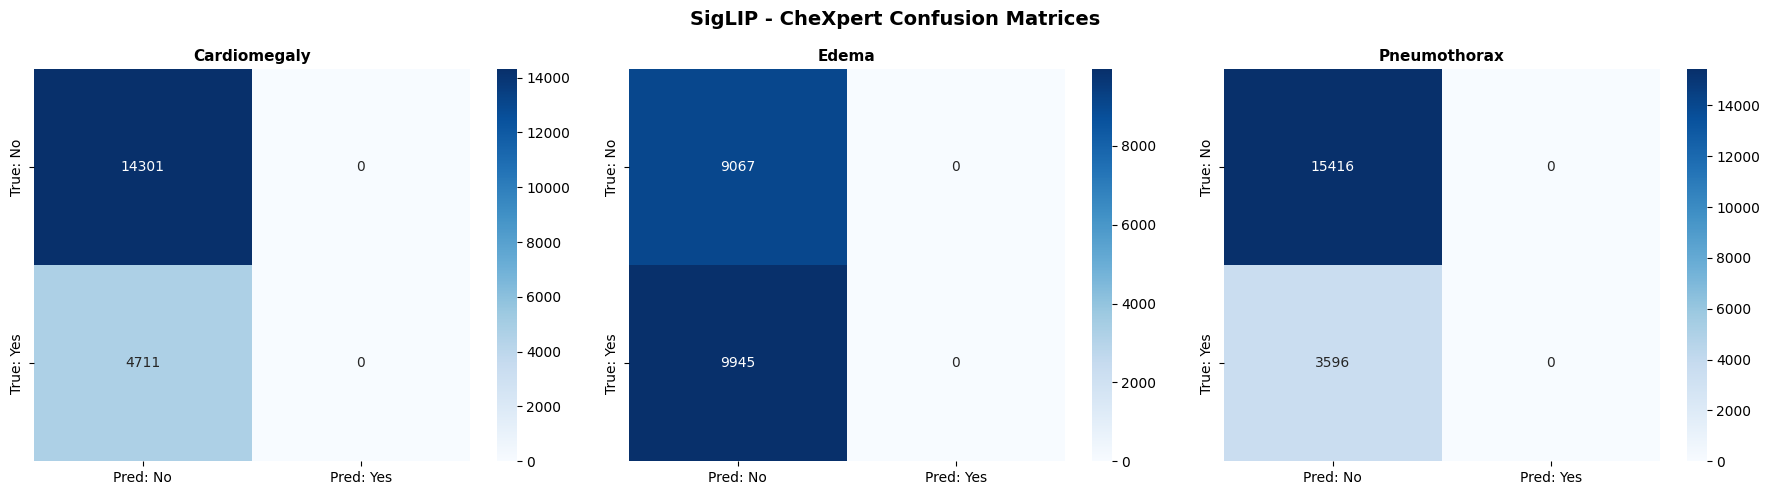

In [13]:
fig, axes = plt.subplots(1, cfg.NUM_CLASSES, figsize=(6 * cfg.NUM_CLASSES, 5))
fig.suptitle("SigLIP - CheXpert Confusion Matrices", fontsize=14, fontweight="bold")
reports_list = []
for i, label in enumerate(cfg.LABELS):
    y_true = all_labels[:, i].astype(int)
    y_pred = all_preds[:, i].astype(int)
    cm = confusion_matrix(y_true, y_pred)
    ax = axes[i]
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax,
                xticklabels=["Pred: No", "Pred: Yes"],
                yticklabels=["True: No", "True: Yes"])
    ax.set_title(label, fontsize=11, fontweight="bold")
    reports_list.append({
        "Label": label,
        "Accuracy":  accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall":    recall_score(y_true, y_pred, zero_division=0),
        "F1-Score":  f1_score(y_true, y_pred, zero_division=0),
    })
plt.tight_layout()
plt.savefig(os.path.join(cfg.OUTPUT_DIR, "siglip_chexpert_confusion_matrices.png"), dpi=150, bbox_inches="tight")
plt.show()
reports_df = pd.DataFrame(reports_list)


## Classification Reports

In [14]:
for i, label in enumerate(cfg.LABELS):
    y_true = all_labels[:, i].astype(int)
    y_pred = all_preds[:, i].astype(int)
    print(f"\n{'='*50}\n  {label}\n{'='*50}")
    print(classification_report(y_true, y_pred, target_names=[f"No {label}", label]))
reports_df.to_csv(os.path.join(cfg.OUTPUT_DIR, "siglip_chexpert_reports.csv"), index=False)
print(reports_df.to_string(index=False))



  Cardiomegaly
                 precision    recall  f1-score   support

No Cardiomegaly       0.75      1.00      0.86     14301
   Cardiomegaly       0.00      0.00      0.00      4711

       accuracy                           0.75     19012
      macro avg       0.38      0.50      0.43     19012
   weighted avg       0.57      0.75      0.65     19012


  Edema
              precision    recall  f1-score   support

    No Edema       0.48      1.00      0.65      9067
       Edema       0.00      0.00      0.00      9945

    accuracy                           0.48     19012
   macro avg       0.24      0.50      0.32     19012
weighted avg       0.23      0.48      0.31     19012


  Pneumothorax
                 precision    recall  f1-score   support

No Pneumothorax       0.81      1.00      0.90     15416
   Pneumothorax       0.00      0.00      0.00      3596

       accuracy                           0.81     19012
      macro avg       0.41      0.50      0.45     19012


## ROC Curves

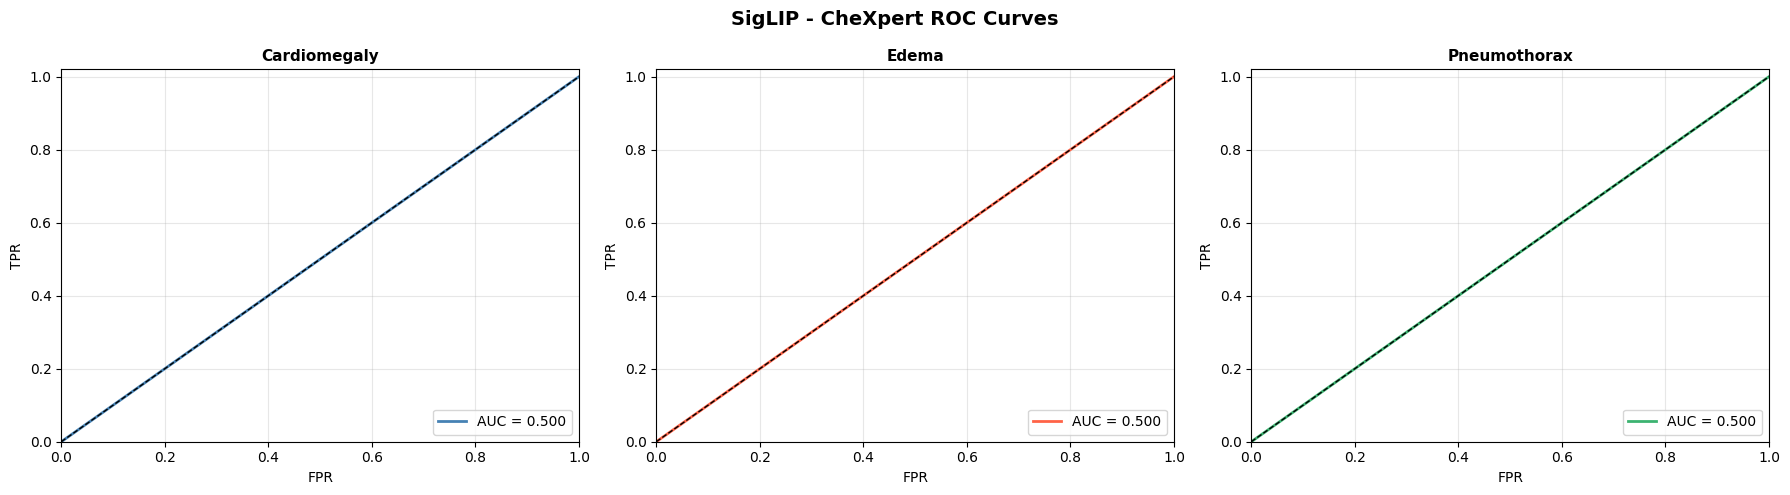

In [15]:
colors = ["steelblue", "tomato", "mediumseagreen"]
fig, axes = plt.subplots(1, cfg.NUM_CLASSES, figsize=(6 * cfg.NUM_CLASSES, 5))
fig.suptitle("SigLIP - CheXpert ROC Curves", fontsize=14, fontweight="bold")
for i, (label, color) in enumerate(zip(cfg.LABELS, colors)):
    fpr, tpr, _ = roc_curve(all_labels[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    ax = axes[i]
    ax.plot(fpr, tpr, color=color, lw=2, label=f"AUC = {roc_auc:.3f}")
    ax.plot([0, 1], [0, 1], "k--", lw=1)
    ax.set_xlim([0, 1]); ax.set_ylim([0, 1.02])
    ax.set_xlabel("FPR"); ax.set_ylabel("TPR")
    ax.set_title(label, fontsize=11, fontweight="bold")
    ax.legend(loc="lower right"); ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(cfg.OUTPUT_DIR, "siglip_chexpert_roc_curves.png"), dpi=150, bbox_inches="tight")
plt.show()


## Per-Class Metrics Comparison

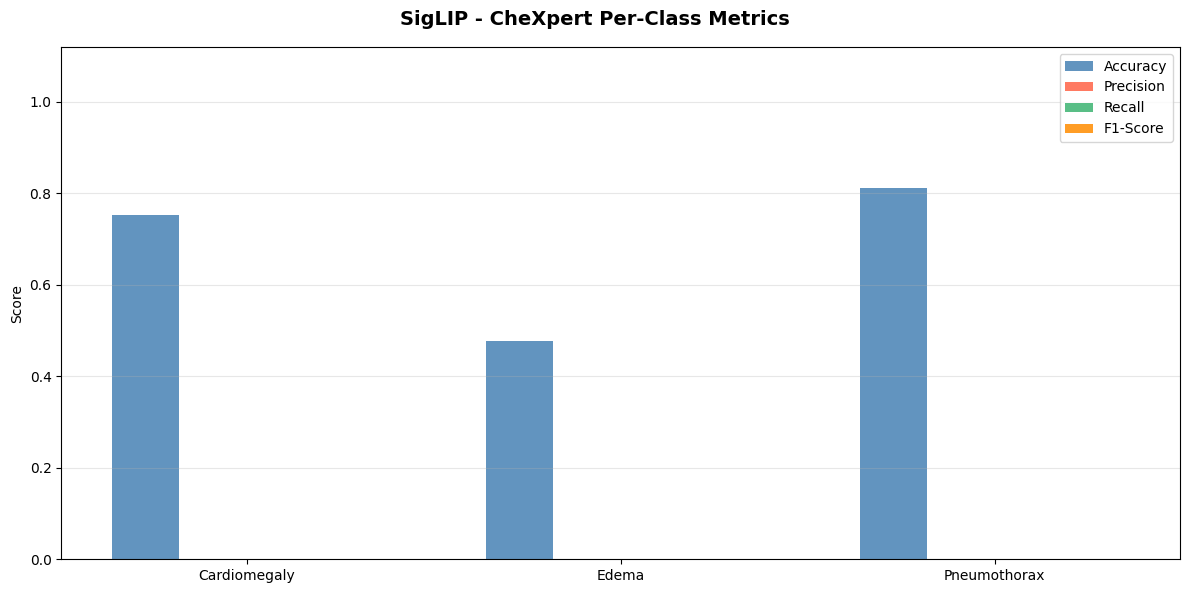

In [16]:
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
mc = ["steelblue", "tomato", "mediumseagreen", "darkorange"]
x = np.arange(len(cfg.LABELS)); w = 0.18
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle("SigLIP - CheXpert Per-Class Metrics", fontsize=14, fontweight="bold")
for j, (met, col) in enumerate(zip(metrics, mc)):
    vals = [reports_df.loc[reports_df["Label"] == lbl, met].values[0] for lbl in cfg.LABELS]
    ax.bar(x + j * w, vals, w, label=met, color=col, alpha=0.85)
ax.set_xticks(x + w * 1.5); ax.set_xticklabels(cfg.LABELS)
ax.set_ylim(0, 1.12); ax.set_ylabel("Score"); ax.legend(); ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(cfg.OUTPUT_DIR, "siglip_chexpert_metrics.png"), dpi=150, bbox_inches="tight")
plt.show()


## Save & Summary

In [17]:
torch.save({
    "model_state_dict": model.state_dict(),
    "config": {"checkpoint": cfg.CHECKPOINT, "num_classes": cfg.NUM_CLASSES,
               "labels": cfg.LABELS, "img_size": cfg.IMG_SIZE},
    "best_val_loss": best_val_loss,
}, os.path.join(cfg.OUTPUT_DIR, "siglip_chexpert_final.pth"))

print("=" * 65)
print("DONE - SigLIP CheXpert")
print("=" * 65)
print(f"  Best Val Loss : {best_val_loss:.4f}")
print(f"  Val Acc       : {history['val_acc'][-1]:.4f}")
print("\nPer-class (val):")
for _, r in reports_df.iterrows():
    print(f"  {r['Label']:20s} Acc={r['Accuracy']:.4f}  F1={r['F1-Score']:.4f}")
print("\nAll outputs saved.")


DONE - SigLIP CheXpert
  Best Val Loss : 1.1506
  Val Acc       : 0.0015

Per-class (val):
  Cardiomegaly         Acc=0.7522  F1=0.0000
  Edema                Acc=0.4769  F1=0.0000
  Pneumothorax         Acc=0.8109  F1=0.0000

All outputs saved.
